In [9]:
# Import Data

import os
import pandas as pd
import numpy as np

cover_path = "/Users/chengminzheng/Downloads/forest_cover_dataset.csv"
cover_column_names=["Elevation","Aspect","Slope",
              "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology",
              "Horizontal_Distance_To_Roadways","Hillshade_9am","Hillshade_Noon",
              "Hillshade_3pm","Horizontal_Distance_To_Fire_Points"]

wilderness_cols =["Wilderness_"+str(i) for i in range(4)]
soil_col =["Soil_"+str(i) for i in range(40)]
cover_columns_names = cover_column_names + wilderness_cols + soil_col

cover_file = pd.read_csv(cover_path)
cover_file.columns = cover_columns_names
cover_data = cover_file
cover_data.head()


In [ ]:
# Determine number of features, one less that the total number of columns as annual-income is the label
num_features=len(cover_data.columns)
print("Number of features:",num_features)

Number of features: 54


In [ ]:
# Feature Type
cover_data.dtypes

Elevation                             int64
Aspect                                int64
Slope                                 int64
Horizontal_Distance_To_Hydrology      int64
Vertical_Distance_To_Hydrology        int64
Horizontal_Distance_To_Roadways       int64
Hillshade_9am                         int64
Hillshade_Noon                        int64
Hillshade_3pm                         int64
Horizontal_Distance_To_Fire_Points    int64
Wilderness_0                          int64
Wilderness_1                          int64
Wilderness_2                          int64
Wilderness_3                          int64
Soil_0                                int64
Soil_1                                int64
Soil_2                                int64
Soil_3                                int64
Soil_4                                int64
Soil_5                                int64
Soil_6                                int64
Soil_7                                int64
Soil_8                          

import numpy as np

#Determine nature of object types
cover_cat_columns=dict()
cover_cat_columns_idx=dict()
cover_num_columns_idx=dict()
for col in cover_column_names:
    if cover_data[col].dtype == 'object':
        cover_cat_columns[col]=cover_data[col].unique()
        cover_cat_columns_idx[col]=cover_data.columns.get_loc(col)
        print(col,":",cover_cat_columns[col])
    elif np.issubdtype(cover_data.at[0,col], np.number):
        cover_num_columns_idx[col]=cover_data.columns.get_loc(col)

In [ ]:
from sklearn.model_selection import ShuffleSplit

# import train_test_split

split = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 23732975)
split1 = ShuffleSplit(n_splits = 1, test_size = 0.25, random_state = 23732975)

for train_valid_index, test_index in split.split(cover_data):
    cover_train_valid_set = cover_data.iloc[train_valid_index]
    cover_test_set = cover_data.iloc[test_index]

for train_index, validation_index in split1.split(cover_train_valid_set):
    cover_validation_set = cover_train_valid_set.iloc[validation_index]
    cover_train_set = cover_train_valid_set.iloc[train_index]


print("Split Complete")

Split Complete


In [ ]:
#Centering Data

center_function = lambda x: x - x.mean()

train_centered = center_function(cover_train_set)
validation_centered = center_function(cover_validation_set)
test_centered = center_function(cover_test_set)

In [ ]:
k_values=list(range(2,11))+[15,20]

from joblib import Parallel, delayed, parallel_backend

with parallel_backend("loky", inner_max_num_threads=2):
    results = Parallel(n_jobs=4)(delayed(func)(x, y) for x, y in cover_data)

In [ ]:
def total_inertia(dataset,centers,labels,distance=None,mean=True):
    """
    Computes the total inertia (the intracluster variance) given a dataset and the cluster centers.
    
    Parameters
    ----------
    dataset : numpy.ndarray
        The dataset to evaluate.
    center : numpy.ndarray or list
        The list of cluster centers.
    distance : function
        A function that computes the pairwise distance between two samples.
        Default: Euclidean (l_2) distance
    mean : bool
        If True, returns the mean inertia.
        Default: True
        
    Returns
    -------
    total_inertia : float
       The mean inertia (if mean==True) or total inertia (if mean==False).
"""
    num_samples,_ = dataset.shape
    total_inertia=0
    if distance is None:
        distance=lambda x,y: np.linalg.norm(x-y)**2
    for i,sample in enumerate(dataset):
        center = centers[labels[i]]
        total_inertia += distance(sample,center)
    
    if mean:
        return total_inertia/num_samples
    else:
        return total_inertia

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics

train_array = []
valid_array = []

for k in k_values:
    km = KMeans(n_clusters = k, random_state = 23732975)
    km.fit(train_centered)
    
    # apply trained model to validation set 
    predict_value = km.predict(validation_centered)

    train_array.append(km)
    valid_array.append(predict_value)

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


In [ ]:
inertia_train = []
for k in range(len(train_array)):
    inertia_train.append(train_array[k].inertia_/len(train_centered))

In [ ]:
# apply to validation
inertia_valid = []
for k in range(len(valid_array)):
    #has to call total_inertia
    #inertia_valid.append(km.inertia_)
    numpy_valid = validation_centered.to_numpy()
    inertia_valid.append(total_inertia(numpy_valid, train_array[k].cluster_centers_, valid_array[k]))

In [ ]:
print(inertia_train)
print(inertia_valid)

[2339940.267891084, 1645241.4227968021, 1270681.578757443, 1009005.1704382563, 885929.9588084134, 767981.8171859712, 691592.0980292887, 632054.1631233694, 578425.7489547932, 420245.4893783086, 342599.8287918712]
[2336115.512259709, 1642584.5939974713, 1272248.3469062268, 1009996.2504271306, 887592.9373266094, 771717.1388089403, 693412.8716147541, 632347.4476270382, 578624.9420668224, 420581.6326461365, 343735.5078704321]


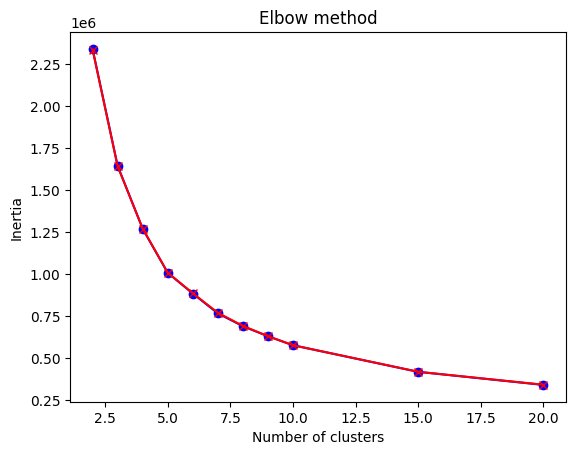

In [ ]:
plt.plot(k_values, inertia_train, marker='o', color = 'blue')
plt.plot(k_values, inertia_valid, marker='x', color = 'red')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# from 10 to 15 clusters can be choosen

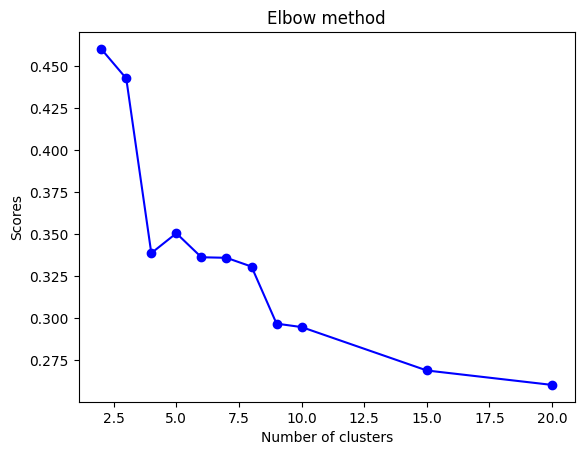

In [ ]:
# 1.2.5
# Silhouette Coefficient

from sklearn.metrics import silhouette_score

scores = []

for k in k_values:
    kmeans = KMeans(n_clusters = k, random_state = 23732975)
    kmeans.fit_predict(validation_centered)
    labels = kmeans.labels_
    #compute for each k
    scores.append(silhouette_score(validation_centered, labels))

plt.plot(k_values, scores, marker='o', color = 'blue')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Scores')
plt.show()

#From 10 to 15 clusters can be choosen. Even though the graph is different, but the choosen cluster is not changed. 

In [ ]:
crime_path = "/Users/chengminzheng/Downloads/crime.csv"

crime_column_names= ['state', 'county', 'community', 'communityname', 'fold', 'population', 'householdsize',
                 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29',
                 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf',
                 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap',
                 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov',
                 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu',
                 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr',
                 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par',
                 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRecent',
                 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5', 'PctRecImmig8',
                 'PctRecImmig10', 'PctSpeakEnglOnly', 'PctNotSpeakEnglWell', 'PctLargHouseFam', 'PctLargHouseOccup',
                 'PersPerOccupHous', 'PersPerOwnOccHous', 'PersPerRentOccHous', 'PctPersOwnOccup', 'PctPersDenseHous',
                 'PctHousLess3BR', 'MedNumBR', 'HousVacant', 'PctHousOccup', 'PctHousOwnOcc', 'PctVacantBoarded',
                 'PctVacMore6Mos', 'MedYrHousBuilt', 'PctHousNoPhone', 'PctWOFullPlumb', 'OwnOccLowQuart', 'OwnOccMedVal',
                 'OwnOccHiQuart', 'RentLowQ', 'RentMedian', 'RentHighQ', 'MedRent', 'MedRentPctHousInc', 'MedOwnCostPctInc',
                 'MedOwnCostPctIncNoMtg', 'NumInShelters', 'NumStreet', 'PctForeignBorn', 'PctBornSameState', 'PctSameHouse85',
                 'PctSameCity85', 'PctSameState85', 'LemasSwornFT', 'LemasSwFTPerPop', 'LemasSwFTFieldOps',
                 'LemasSwFTFieldPerPop', 'LemasTotalReq', 'LemasTotReqPerPop', 'PolicReqPerOffic',
                 'PolicPerPop', 'RacialMatchCommPol', 'PctPolicWhite', 'PctPolicBlack', 'PctPolicHisp',
                 'PctPolicAsian', 'PctPolicMinor', 'OfficAssgnDrugUnits', 'NumKindsDrugsSeiz', 'PolicAveOTWorked',
                 'LandArea', 'PopDens', 'PctUsePubTrans', 'PolicCars', 'PolicOperBudg', 'LemasPctPolicOnPatr',
                 'LemasGangUnitDeploy', 'LemasPctOfficDrugUn', 'PolicBudgPerPop', 'ViolentCrimesPerPop']

crime_file = pd.read_csv(crime_path)
crime_file.columns = crime_column_names
crime_data = crime_file
crime_data.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.0,?,0.67
1,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.0,?,0.43
2,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.0,?,0.12
3,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.0,?,0.03
4,6,?,?,SouthPasadenacity,1,0.02,0.28,0.06,0.54,1.00,...,0.01,0.58,0.10,?,?,?,?,0.0,?,0.14


In [ ]:
# 2.1.1
# Determine number of features, one less that the total number of columns as annual-income is the label

num_features=len(crime_data.columns)
print("Number of features:",num_features)

Number of features: 128


In [ ]:
# 2.1.1
# Feature Type
crime_data.dtypes

state                    int64
county                  object
community               object
communityname           object
fold                     int64
                        ...   
LemasPctPolicOnPatr     object
LemasGangUnitDeploy     object
LemasPctOfficDrugUn    float64
PolicBudgPerPop         object
ViolentCrimesPerPop    float64
Length: 128, dtype: object

In [ ]:
# 2.1.4
# preprocessing

# Convert ? to NaN
missing_values = ["n/a", "na", "?", "missing"]
mapper = {m:np.nan for m in missing_values}
crime_data = crime_data.replace(mapper) 

# drop column that has all NaN value
crime_data = crime_data.dropna(axis = 1, how = 'all')

# drop columns
crime_data = crime_data.drop(columns = ['communityname', 'community', 'MedNumBR', 'LemasGangUnitDeploy', 'fold'])

# delete columns containing either 50% or more than 50% NaN Values
min_count =  int(0.5*crime_data.shape[0] + 1)
crime_data = crime_data.dropna(axis = 1, thresh = min_count)


# Fill NaN with median value
crime_data = crime_data.fillna(crime_data.median())

crime_data.head()

,state,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,53,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,...,0.21,0.50,0.34,0.60,0.52,0.02,0.12,0.45,0.0,0.67
1,24,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,...,0.14,0.49,0.54,0.67,0.56,0.01,0.21,0.02,0.0,0.43
2,34,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,...,0.19,0.30,0.73,0.64,0.65,0.02,0.39,0.28,0.0,0.12
3,42,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,...,0.11,0.72,0.64,0.61,0.53,0.04,0.09,0.02,0.0,0.03
4,6,0.02,0.28,0.06,0.54,1.00,0.25,0.31,0.48,0.27,...,0.70,0.42,0.49,0.73,0.64,0.01,0.58,0.10,0.0,0.14


In [ ]:
# 2.1.2
# import train_test_split

split = ShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 23732975)
split1 = ShuffleSplit(n_splits = 1, test_size = 0.25, random_state = 23732975)

for train_valid_index, test_index in split.split(crime_data):
    crime_train_valid_set = crime_data.loc[train_valid_index]
    crime_test_set = crime_data.loc[test_index]


for train_index, validation_index in split1.split(crime_train_valid_set):
    crime_validation_set = crime_train_valid_set.iloc[validation_index]
    crime_train_set = crime_train_valid_set.iloc[train_index]

print("Split Complete")

Split Complete


from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values = np.nan, strategy ='median')


#Turn the numpy array back into a dataframe so you can use it
crime_train_set = imputer.fit_transform(crime_train_set)
crime_train_set = pd.DataFrame(crime_train_set)

#Next, we transform the other sets
#Turn the numpy arrays back into a dataframe so you can use it
crime_validation_set = imputer.transform(crime_validation_set)
crime_validation_set = pd.DataFrame(crime_validation_set)

crime_test_set = imputer.transform(crime_test_set)
crime_test_set = pd.DataFrame(crime_test_set)

crime_train_valid_set = imputer.transform(crime_train_valid_set)
crime_train_valid_set = pd.DataFrame(crime_train_valid_set)


In [ ]:
# separate features and labels

X_train = crime_train_set.drop('ViolentCrimesPerPop',axis=1)
Y_train = crime_train_set['ViolentCrimesPerPop']
X_validation = crime_validation_set.drop('ViolentCrimesPerPop',axis=1)
Y_validation = crime_validation_set['ViolentCrimesPerPop']

X_test = crime_test_set.drop('ViolentCrimesPerPop', axis = 1)
Y_test = crime_test_set['ViolentCrimesPerPop']

X_train_valid = crime_train_valid_set.drop('ViolentCrimesPerPop',axis=1)
Y_train_valid = crime_train_valid_set['ViolentCrimesPerPop']

In [ ]:
# 2.1.3
# Cross Validation

from sklearn.model_selection import KFold

skf = KFold(n_splits = 5, shuffle = True, random_state = 23732975)
skf.get_n_splits(crime_train_valid_set)

5

In [ ]:
#peformance metric functions

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

#A list of keys for the dictionary returned by p1_metrics
metric_keys = ['mse','mae','r2']

def p2_metrics(y_true,y_pred,negation=False):
    if negation:
        sign = -1
    else:
        sign = 1
    return {
        'mse': sign*mean_squared_error(y_true,y_pred),
        'mae': sign*mean_absolute_error(y_true,y_pred),
        'r2': sign*r2_score(y_true,y_pred)}

#This wrapper can be used to return multiple performance metrics during cross-validation
def p2_metrics_scorer(clf,X,y_true):
    y_pred=clf.predict(X)
    return p2_metrics(y_true,y_pred,negation=True)

In [ ]:
# 2.2.1
# Construct Linear Regression

from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, Y_train)
regressor.intercept_, regressor.coef_


(0.4676117911167802,
 array([-6.30094664e-04,  3.02279787e-01, -1.04553119e-01,  1.63510522e-01,
        -4.79058157e-02,  1.51751643e-03,  9.79420412e-02,  1.59231170e-01,
        -1.67888457e-01, -1.83566244e-01,  1.16482478e-01, -4.79152246e-01,
         4.78867278e-02, -2.52137711e-01, -2.17281296e-01,  5.44000676e-02,
        -7.65114713e-02,  5.92148049e-02, -7.62101337e-02, -1.13681234e-01,
         4.63596237e-01, -4.62685921e-02, -2.78122062e-01, -2.83030478e-02,
        -4.62834397e-02,  2.36085874e-02,  6.06075623e-03,  5.91341685e-02,
         3.23707830e-01, -1.83322091e-01,  3.08373524e-02, -7.47286771e-02,
        -2.48377545e-02,  4.65097922e-04,  2.35451999e-01, -4.39796745e-02,
        -3.22552099e-02,  1.52078334e-02,  1.46844817e-01,  5.47027043e-01,
         2.26039400e-01,  2.69460297e-01, -7.21171224e-01, -1.13981378e-01,
         2.56252633e-01, -5.64335856e-01, -4.82163283e-02, -6.98664729e-03,
         7.15141872e-02, -1.58121724e-01, -1.24191257e-01,  1.50981

In [ ]:
# 2.2.2
# Performance metrics
regressor_y_predict = regressor.predict(X_train)
regressor_metrics = p2_metrics(Y_train, regressor_y_predict)
for metric in regressor_metrics:
    print(metric + ":", regressor_metrics[metric])

#The model is underfitting, because the model performs poorly on the training data.

mse: 0.014769790707478353
mae: 0.08580033086303346
r2: 0.7273804467076748


In [ ]:
# 2.2.3

weights = regressor.coef_
features = X_train.columns
crime_data = pd.DataFrame({'Features': features, 'Weights': weights})
crime_data.sort_values(by='Weights', inplace=True, ascending = True)

# Print the dataframe
print(crime_data.to_string())

# Print the most significant features
print('The most significant features are: {}'.format(', '.join(crime_data['Features'].values[:3])))

# Print the least significant features
print('The least significant features are: {}'.format(', '.join(crime_data['Features'].values[-3:])))

# Print the correlation of the most significant features
print('The correlation of the most significant features is: {}'.format(crime_data['Weights'].values[:3].mean()))

# Print the correlation of the least significant features
print('The correlation of the least significant features is: {}'.format(crime_data['Weights'].values[-3:].mean()))


                 Features   Weights
42            TotalPctDiv -0.721171
45            PctKids2Par -0.564336
60          PctRecImmig10 -0.515117
11              numbUrban -0.479152
79         OwnOccLowQuart -0.464909
68        PctPersOwnOccup -0.446042
64      PctLargHouseOccup -0.354609
55           PctImmigRec8 -0.295461
58           PctRecImmig5 -0.279966
22            whitePerCap -0.278122
13              medIncome -0.252138
66      PersPerOwnOccHous -0.242486
67     PersPerRentOccHous -0.229720
14               pctWWage -0.217281
52               NumImmig -0.206266
82               RentLowQ -0.205343
9             agePct16t24 -0.183566
29         PctPopUnderPov -0.183322
62    PctNotSpeakEnglWell -0.171136
8             agePct12t29 -0.167888
49             PctWorkMom -0.158122
57         PctRecentImmig -0.155279
50               NumIlleg -0.124191
43             PersPerFam -0.113981
19             pctWRetire -0.113681
2           householdsize -0.104553
16             pctWInvInc -0

In [ ]:
# 2.3.1

from sklearn.decomposition import PCA

pca = PCA(n_components = 1)
pca.fit(crime_train_set)
print('Number of Component:', pca.n_components)
print(pca.explained_variance_ratio_)

Number of Component: 1
[0.98573481]


In [ ]:
# 2.3.2

principal_component_validation = pca.fit_transform(crime_validation_set)
principal_component_test = pca.fit_transform(crime_test_set)

In [ ]:
# Construct Linear Regression

from sklearn.linear_model import LinearRegression

X_pca = pca.fit_transform(X_train)
regressor_new = LinearRegression()
regressor_new.fit(X_pca, Y_train)

LinearRegression()

In [ ]:
# Performance metrics
regressor_y_predict = regressor_new.predict(principal_component_validation)
regressor_metrics = p2_metrics(Y_validation, regressor_y_predict)
for metric in regressor_metrics:
    print(metric + ":", regressor_metrics[metric])

mse: 0.050377928164966834
mae: 0.16519007331146715
r2: 0.025157366373178225


In [ ]:
#Summarizes model performance results produced during hyperparameter tuning
def collate_ht_results(ht_results,metric_keys=metric_keys,display=True):
    ht_stats=dict()
    for metric in metric_keys:
        ht_stats[metric+"_mean"] = ht_results.cv_results_["mean_test_"+metric][ht_results.best_index_]
        ht_stats[metric+"_std"] = metric_std = ht_results.cv_results_["std_test_"+metric][ht_results.best_index_]
        if display:
            print("test_"+metric,ht_stats[metric+"_mean"],"("+str(ht_stats[metric+"_std"])+")")
    return ht_stats

In [ ]:
alphas = 10**np.linspace(1,-3,50)*0.5

In [ ]:
# 2.4.1
# LASSO

import time
from sklearn.linear_model import Lasso
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

start = time.time()

lasso_params = {'alpha': (alphas), 'random_state': [23732975]}
lasso = linear_model.Lasso(random_state = 23732975)

gs_lasso = GridSearchCV(lasso, param_grid = lasso_params, scoring = p2_metrics_scorer, refit = "mse", cv = skf, return_train_score = False, n_jobs = -1)
gs_lasso.fit(X_train_valid, Y_train_valid)

end = time.time()


In [ ]:
# 2.4.2
# Report

print('Total Time Cost:', (end - start), 's')
print("Best Parameters:", gs_lasso.best_params_)
gs_lasso_stats = collate_ht_results(gs_lasso)
print(gs_lasso_stats)


Total Time Cost: 23.281533002853394 s
Best Parameters: {'alpha': 0.0005, 'random_state': 23732975}
test_mse -0.01796838435395707 (0.002554291192866726)
test_mae -0.09236277320498441 (0.004715742948695101)
test_r2 -0.6648170411410457 (0.02328244326343272)
{'mse_mean': -0.01796838435395707, 'mse_std': 0.002554291192866726, 'mae_mean': -0.09236277320498441, 'mae_std': 0.004715742948695101, 'r2_mean': -0.6648170411410457, 'r2_std': 0.02328244326343272}


In [ ]:
# Report weight
weights = gs_lasso.best_estimator_.coef_
features = X_train.columns
crime_data = pd.DataFrame({'Features': features, 'Weights': weights})
crime_data.sort_values(by='Weights', inplace=True, ascending = True)

# Print the dataframe
print(crime_data.to_string())

#print how many non zero
print('Non Zero Features Count:', np.count_nonzero(crime_data['Weights'], axis=0))



                 Features   Weights
45            PctKids2Par -0.193243
72           PctHousOccup -0.065148
49             PctWorkMom -0.049317
46       PctYoungKids2Par -0.039953
4            racePctWhite -0.039039
88  MedOwnCostPctIncNoMtg -0.017842
14               pctWWage -0.016772
82               RentLowQ -0.009677
19             pctWRetire -0.008713
16             pctWInvInc -0.008203
8             agePct12t29 -0.008079
35            PctEmplManu -0.003533
0                   state -0.000924
13              medIncome -0.000000
70         PctHousLess3BR  0.000000
68        PctPersOwnOccup -0.000000
67     PersPerRentOccHous  0.000000
66      PersPerOwnOccHous -0.000000
65       PersPerOccupHous  0.000000
64      PctLargHouseOccup  0.000000
63        PctLargHouseFam  0.000000
62    PctNotSpeakEnglWell  0.000000
61       PctSpeakEnglOnly -0.000000
59           PctRecImmig8  0.000000
58           PctRecImmig5  0.000000
57         PctRecentImmig  0.000000
55           PctImmigRec8 -0

In [ ]:
# 2.5.1
# Determine best choice of hyperparameter for MLP

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

start = time.time()
num_layers=[1,2,3]
num_neurons = [10,20,50]
hidden_layers = list()
for i in num_layers:
    for j in num_neurons:
        hidden_layers.append([j]*i)
learning_rates = [1e-5,1e-4,0.001,0.01,0.1, 0.5,1,5,10,50,100]
mlp_gs_params={'hidden_layer_sizes':hidden_layers, 'learning_rate_init':learning_rates}
mlp_gs = GridSearchCV(
    MLPRegressor(random_state=189973487, max_iter=10000,early_stopping=True),
    mlp_gs_params,
    scoring=p2_metrics_scorer,
    refit='mse',
    cv=skf,
    n_jobs=-1,
    return_train_score=False)
mlp_gs=mlp_gs.fit(X_train_valid, Y_train.to_numpy().reshape(-1))

end = time.time()

/Users/chengminzheng/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/chengminzheng/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/chengminzheng/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/chengminzheng/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/Users/chengminzheng/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


In [ ]:
# 2.5.2
# Report
print('Total Time Cost:', (end - start),'s')
print('params', gs_mlp.best_params_)
gs_mlp_stats = collate_ht_results(gs_mlp)
print(gs_mlp_stats)

Total Time Cost: 60.0162250995636 s
params {'hidden_layer_sizes': (20, 20, 20), 'random_state': 23732975}
test_mse -0.01954276520878872 (0.002242768467186745)
test_mae -0.09685100481870448 (0.0050200412604872)
test_r2 -0.6336019880782778 (0.03312418551630424)
{'mse_mean': -0.01954276520878872, 'mse_std': 0.002242768467186745, 'mae_mean': -0.09685100481870448, 'mae_std': 0.0050200412604872, 'r2_mean': -0.6336019880782778, 'r2_std': 0.03312418551630424}


In [ ]:
# 2.6.1
# Construct Final Models

final_regressor = LinearRegression()
final_regressor.fit(X_train_valid, Y_train_valid)
final_regressor_y_predict = final_regressor.predict(X_train_valid)

X_full_pca = pca.fit_transform(X_train_valid)
final_pca_regressor = LinearRegression()
final_pca_regressor.fit(X_full_pca, Y_train_valid)
final_pca_regressor_y_predict = final_pca_regressor.predict(X_full_pca)

final_lasso = linear_model.Lasso(alpha = 0.005, random_state = 23732975)
final_lasso.fit(X_test,Y_test)
final_lasso_y_predict = final_lasso.predict(X_test)

final_mlp = MLPRegressor(hidden_layer_sizes = (20, 20, 20), random_state = 23732975)
final_mlp.fit(X_test, Y_test)
final_mlp_y_predict = final_mlp.predict(X_test)

print('Complete Construct Final Models')

Complete Construct Final Models


In [ ]:
# Obtain Data

import re

def obtain_data(data):
    mse_list = []
    mae_list = []
    r2_list = []

    for element in data:
        if re.search('mse', element):
            mse_list.append(data[element])
        if re.search('mae', element):
            mae_list.append(data[element])
        if re.search('r2', element):
            r2_list.append(data[element])
    return mse_list, mae_list, r2_list

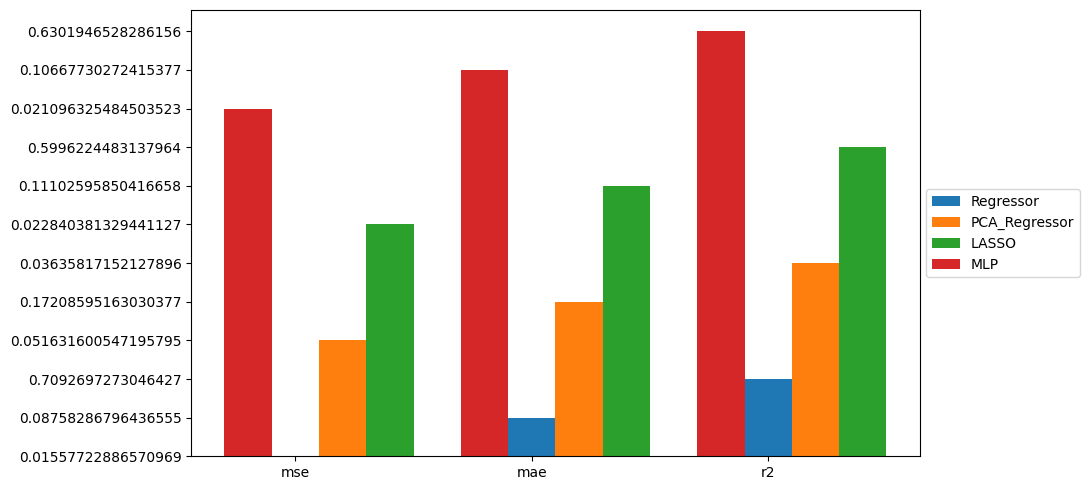

In [ ]:
# 2.6.2
# Bar Chart

X_pos = np.arange(len(metric_keys))
labels = metric_keys
width = 0.2

v_regressor = p2_metrics(Y_train_valid, final_regressor_y_predict)
v_pca_regressor = p2_metrics(Y_train_valid, final_pca_regressor_y_predict)
v_lasso = p2_metrics(Y_test, final_lasso_y_predict)
v_mlp = p2_metrics(Y_test, final_mlp_y_predict)

regressor_mse, regressor_mae, regressor_r2 = obtain_data(v_regressor)
pca_regressor_mse, pca_regressor_mae, pca_regressor_r2 = obtain_data(v_pca_regressor)
lasso_mse, lasso_mae, lasso_r2 = obtain_data(v_lasso)
mlp_mse, mlp_mae, mlp_r2 = obtain_data(v_mlp)

result1 = ' '.join(str(item) for item in regressor_mse)
result2 = ' '.join(str(item) for item in regressor_mae)
result3 = ' '.join(str(item) for item in regressor_r2)

result4 = ' '.join(str(item) for item in pca_regressor_mse)
result5 = ' '.join(str(item) for item in pca_regressor_mae)
result6 = ' '.join(str(item) for item in pca_regressor_r2)

result7 = ' '.join(str(item) for item in lasso_mse)
result8 = ' '.join(str(item) for item in lasso_mae)
result9 = ' '.join(str(item) for item in lasso_r2)

result10 = ' '.join(str(item) for item in mlp_mse)
result11 = ' '.join(str(item) for item in mlp_mae)
result12 = ' '.join(str(item) for item in mlp_r2)

regressor_list = [result1, result2, result3]
pca_regressor_list = [result4, result5, result6]
lasso_list = [result7, result8, result9]
mlp_list = [result10, result11, result12]

fig, ax = plt.subplots()

ax.bar(X_pos, regressor_list, width, label = 'Regressor')
ax.bar(X_pos+0.2, pca_regressor_list, width, label = 'PCA_Regressor')
ax.bar(X_pos+0.4, lasso_list, width, label = 'LASSO')
ax.bar(X_pos-0.2, mlp_list, width, label = 'MLP')

ax.set_xticks(X_pos,labels)
#ax.set_xticklabels(labels)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(11, 5, forward=True)
fig.tight_layout()
plt.show()

#2.6.3

As result, MLP has better performance., and linear regression without pca has the worse performance. 